# TRSpectrometer Data Format Demonstration

You can download the notebook as a `.ipynb` file {nb-download}`demo_trdata.ipynb` and use it yourself. Running this notebook requires `zarr` to open the data directories, `numpy` for data manipulation, and `matplotlib` for plotting.

In [1]:
import os
from datetime import datetime

import zarr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Loading a .tr.zarr Data Directory

We will first find a suitable data directory and load it up. The data format is stored in [zarr format](https://zarr.readthedocs.io>), which can store multidimensional arrays in a chunked, compressed form. Metadata fields can also be stored alongside the raw data arrays.

In [2]:
# List .tr.zarr data in the specified data_dir
data_dir = "./TRData"

file_list = [ f for f in os.listdir(data_dir) if f.endswith(".tr.zarr") ]
file_list.sort()
for i, f in enumerate(file_list):
    print(f"{i:3d} : {f}")

FileNotFoundError: [Errno 2] No such file or directory: './TRData'

In [5]:
# Select a file index from the above list to load
file_i = 0

filename = os.path.join(data_dir, file_list[file_i])
z = zarr.open(filename)
print(f"Loaded zarr array from: {filename}")

Loaded zarr array from: ./TRData/211101_143354-TIPS-Pn_NP_Crystalline_2-700nm-swept.tr.zarr


## Exploring the Data Structure

The zarr data object is now referenced by the `z` variable. We can use the zarr `tree()` method to display the structure of the object, though it doesn't list any included metadata.

In [4]:
print(z.tree())

/
 └── raw
     ├── data (15, 611, 2560) float32
     ├── data_density (15, 611) uint32
     ├── time (611,) float32
     └── wavelength (2560,) float32


As of version 1.0 of the TRSpectrometer software, the application is only able to acquire raw data sets. The raw data is stored under the root (`/`) in the `raw` group.
It can be seen that there are four arrays in the `raw` group:

* `data` which contains the raw data values. The axes are (scans, time, wavelength).
* `data_density` is optional, and included when using the swept acquisition method. It stores the number of individual samples which were acquired at each time point for each scan.
  This information may be useful to ensure sufficient sampling was taken at each time point.
* `time` contains the labels for the time axis.
* `wavelength` contains the labels for the wavelength axis.

To access the array data, use the python dictionary syntax to get the desired array. A filesystem "path-like" key can be used as a shorthand:

In [5]:
z['raw']['time'] == z['raw/time']

True

A zarr Array object is similar to a standard numpy ndarray, but there is a subtle difference. The zarr array remains on disk, and elements loaded into RAM only when necessary (did you notice that opening the zarr was very fast, even though it may be hundreds of megabytes in size?)
Some functions will only work as expected with actual numpy arrays, which are produced using numpy array slicing syntax. Here we get all elements from the zarr array using the `[:]` slice.
Note also that there are also some differences between [advanced index slicing for zarr](https://zarr.readthedocs.io/en/stable/tutorial.html#advanced-indexing) versus numpy arrays.

In [24]:
print(f"This is printing a zarr array. The actual values aren't loaded from disk yet:\n{z['raw/time']}")
# print(f"Try this instead. The [:] slice causes the data to be loaded into RAM:\n{z['raw/time'][:]}")

This is printing a zarr array. The actual values aren't loaded from disk yet:
<zarr.core.Array '/raw/time' (611,) float32>


Some functions, such as many from numpy, work fine with zarr arrays without requiring slicing:

In [25]:
print(f"Time ranges from {np.nanmin(z['raw/time'])} to {np.nanmax(z['raw/time'])}")
print(f"Wavelength ranges from {np.nanmin(z['raw/wavelength']):0.1f} to {np.nanmax(z['raw/wavelength']):0.1f}")

Time ranges from 0.0 to 7635.0
Wavelength ranges from 486.0 to 930.3


### Metadata

There is metadata ("data about the data") stored alongside zarr Groups or Arrays. It is accessed using the `attrs[]` dictionary associated with a Group or Array object.
Here, we will make our own custom function to display the contents of the zarr, including the metadata attributes.
Note that this function is only for demonstration purposes and isn't required to actually view or analyse a data set.

In [26]:
def format_metadata(x, html=False, newline=False):
    """
    Display a zarr structure tree, including metadata stored inside the z.attrs[...] dictionary.
    
    This is a recursive function which can also format dict, list, string, numeric or other types.
    A "·" symbol prefix indicates the item is extracted from the zarr Group or Array's ``.attrs[]`` metadata dictionary.
    
    HTML formatted output can be generated by using the ``html=True`` parameter.
    The ``newline`` parameter is used internally during recursion and thus should not be used by the user.
    
    :param x: The item to format to a string.
    :param html: Use HTML output.
    :returns: String format of ``x``.
    """
    returnstring = ""
    keytag_open = "<b>" if html else ""
    keytag_close = "</b>" if html else ""
    lineend = "<br>" if html else "\n"
    indent = "&nbsp;&nbsp;" if html else "  "
    if type(x) == dict or type(x) == zarr.hierarchy.Group:
        if newline:
            returnstring += lineend
        else:
            newline = True
        for k, v in sorted(x.items()):
            returnstring += f"{keytag_open}{k}{keytag_close} : {format_metadata(v, html=html, newline=newline).replace(lineend, lineend + indent)}{lineend}"
        returnstring = returnstring.rpartition(lineend)[0]
    elif type(x) == zarr.hierarchy.Array:
        returnstring += f"array of shape={x.shape}, dtype={x.dtype}"
    elif type(x) == list:
        returnstring += "["
        for v in x:
            returnstring += f"{format_metadata(v, html=html, newline=newline)}, "
        if len(x) > 0:
            returnstring = returnstring[:-2]
        returnstring += "]"
    else:
        returnstring += f"{x}"
    # Metadata in zarr groups or arrays
    if type(x) == zarr.hierarchy.Group or type(x) == zarr.core.Array:
        if len(x.attrs) > 0:
            returnstring += lineend
        for k, v in sorted(x.attrs.items()):
            # The full configuration file used during acquisition is stored in the metadata too, ignore it
            if k == "config": continue
            returnstring += f"·{keytag_open}{k}{keytag_close} : {format_metadata(v, html=html, newline=newline).replace(lineend, lineend + indent)}{lineend}"
        if len(x.attrs) > 0:
            returnstring = returnstring.rpartition(lineend)[0]    
    return returnstring

In [27]:
print(format_metadata(z))

raw : 
  data : array of shape=(15, 611, 2560), dtype=float32
    ·start_stop_times : [[2021-11-01T14:18:50.810750+10:30, 2021-11-01T14:19:55.068637+10:30], [2021-11-01T14:19:55.071602+10:30, 2021-11-01T14:20:51.632108+10:30], [2021-11-01T14:20:51.634104+10:30, 2021-11-01T14:21:47.935005+10:30], [2021-11-01T14:21:47.937971+10:30, 2021-11-01T14:22:46.712002+10:30], [2021-11-01T14:22:46.713998+10:30, 2021-11-01T14:23:45.037911+10:30], [2021-11-01T14:23:45.040915+10:30, 2021-11-01T14:24:43.256914+10:30], [2021-11-01T14:24:43.259879+10:30, 2021-11-01T14:25:43.131841+10:30], [2021-11-01T14:25:43.134835+10:30, 2021-11-01T14:26:39.888670+10:30], [2021-11-01T14:26:39.891663+10:30, 2021-11-01T14:27:37.050448+10:30], [2021-11-01T14:27:37.052443+10:30, 2021-11-01T14:28:44.826298+10:30], [2021-11-01T14:28:44.829289+10:30, 2021-11-01T14:29:42.485525+10:30], [2021-11-01T14:29:42.488518+10:30, 2021-11-01T14:30:40.848995+10:30], [2021-11-01T14:30:40.851990+10:30, 2021-11-01T14:31:39.148757+10:30], [20

Note the `·` symbol denotes a metadata attribute.

We can make use of these attributes, for example, to get the units for labelling the time and wavelength axis labels:

In [28]:
print(f"Time ranges from {np.nanmin(z['raw/time'])} to {np.nanmax(z['raw/time'])} {z['raw/time'].attrs['units']}")
print(f"Wavelength ranges from {np.nanmin(z['raw/wavelength']):0.1f} to {np.nanmax(z['raw/wavelength']):0.1f} {z['raw/wavelength'].attrs['units']}")

Time ranges from 0.0 to 7635.0 ps
Wavelength ranges from 486.0 to 930.3 nm


Or to find out information about when the data was collected and how long it took:

In [29]:
operator = z['raw'].attrs['operator']
time_start = z['raw/data'].attrs['start_stop_times'][0][0]
time_stop = z['raw/data'].attrs['start_stop_times'][-1][0]
duration_mins = (datetime.fromisoformat(time_stop) - datetime.fromisoformat(time_start)).total_seconds()/60
print(f"Raw data was acquired by {operator} on {time_start} and took {duration_mins:0.0f} mins.")

Raw data was acquired by Patrick on 2021-11-01T14:18:50.810750+10:30 and took 14 mins.


The `raw/data` array contains every data point from every individual scan. The `exclude_scans` attribute indicates scan indices which should be excluded from any further processing. We can turn that into a list of scan indices which should be included, which should be valid to use for numpy array slicing:

In [7]:
include_scans = [i for i in range(z['raw/data'].shape[0]) if i not in z['raw'].attrs['exclude_scans']]
print(f"Scans to include in analysis: {include_scans}")

Scans to include in analysis: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


## Slicing and Plotting Data

Now that we know how the data is structured and how to access it, we can begin to actually make use of it. We first show some temporal or kinetic traces, which are plots of signal versus time and one selected wavelength.

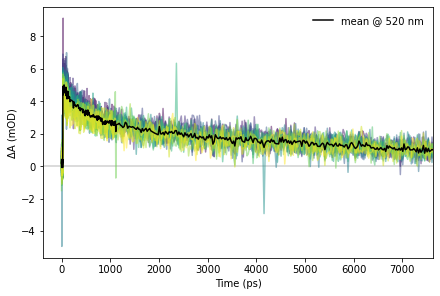

In [9]:
# Wavelength selection for the temporal slice
wl = 520.0
################################################################################

# Wavelength index for this plot slice
w_i = np.argmin(np.abs(z["raw/wavelength"][:] - wl))

# Colours for the plot traces picked from a colormap
cm = mpl.cm.get_cmap("viridis")
colours = [ cm(i/max(len(include_scans) - 1, 1)) for i in include_scans ]

# Build the plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
# Add a horizontal zero line
ax.axhline(0, c="#d0d0d0")

# Extract the wavelength (spectral) slices from the zarr and plot each included scan
s_slice = z['raw/data'][:,:,w_i]
for s_i, scan in enumerate(s_slice[include_scans]):
    ax.plot(z["raw/time"], 1e3*scan, c=colours[s_i], alpha=0.5)

# Add a trace for the mean
ax.plot(z["raw/time"], 1e3*np.nanmean(s_slice[include_scans], axis=0), c="black", label=f"mean @ {wl:0.0f} {z['raw/wavelength'].attrs['units']}")

# Finish garnishing the plot
ax.set_xlabel(f"Time ({z['raw/time'].attrs['units']})")
ax.set_ylabel(f"{z['raw/data'].attrs['units']} (mOD)")
ax.set_xlim(None, np.max(z['raw/time']))
ax.legend(frameon=False)

# Save the image if desired
#fig.savefig(f"temporal_slice_{wl:0.0f}{z['raw/wavelength'].attrs['units']}.pdf", dpi=300)
pass # Hide notebook output text

Spectral slices are plots of signal as a function of wavelength at a given time, are are done in a similar manner.

In [10]:
# Time selection for the spectral slice
t = 200.0
################################################################################

# Time index for this plot slice
t_i = np.argmin(np.abs(z["raw/time"][:] - t))

# Colours for the plot traces picked from a colormap
cm = mpl.cm.get_cmap("viridis")
colours = [ cm(i/max(len(include_scans) - 1, 1)) for i in include_scans ]

# Build the plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
# Add a horizontal zero line
ax.axhline(0, c="#d0d0d0")

# Extract the temporal slices from the zarr and plot each included scan
t_slice = z['raw/data'][:,t_i,:]
for s_i, scan in enumerate(t_slice[include_scans]):
    ax.plot(z["raw/wavelength"], 1e3*scan, c=colours[s_i], alpha=0.5)

# Add a trace for the mean
ax.plot(z["raw/wavelength"], 1e3*np.nanmean(t_slice[include_scans], axis=0), c="black", label=f"mean @ {t:0.0f} {z['raw/time'].attrs['units']}")

# Finish garnishing the plot
ax.set_xlabel(f"Wavelength ({z['raw/wavelength'].attrs['units']})")
ax.set_ylabel(f"{z['raw/data'].attrs['units']} (mOD)")
ax.set_xlim(np.min(z['raw/wavelength']), np.max(z['raw/wavelength']))
ax.legend(frameon=False)

# Save the image if desired
#fig.savefig(f"spectral_slice_{t:0.0f}{z['raw/time'].attrs['units']}.pdf", dpi=300)
pass # Hide notebook output text

Plotting a "heatmap" type overview of the data should use the matplotlib `pcolormesh`, which handles a non-uniform time axis properly. Be aware that the time axis will often have variable step sizes, so interpolation onto a regular grid may be needed for some plots or analysis techniques (for example, a Fourier transform).

Text(0, 0.5, 'Time (ps)')

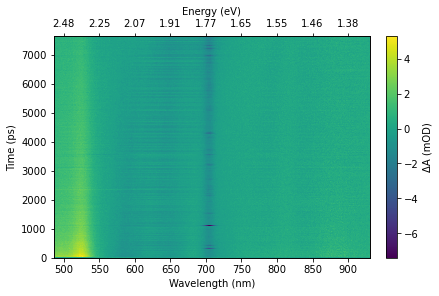

In [33]:
# Choose colour map and range of intensity values to use for plot
cmap = "viridis"
z_range = (None, None)
################################################################################ 

# Use selected scans for average of entire data set
data_mean = 1e3*np.nanmean(z['raw/data'][:][include_scans], axis=0)

# Build the plot
fig, ax = plt.subplots(1, 1, figsize=(6,4), constrained_layout=True)
# Add an upper eV scale if wavelength in nm
if z['raw/wavelength'].attrs['units'] == "nm":
    ax_ev = ax.twiny()
    ax_ev.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f"{1240.0/x:0.2f}" if not x == 0 else 0))
    ax_ev.set_xlabel("Energy (eV)")
    ax.callbacks.connect('xlim_changed', lambda ax_wl: ax_ev.set_xlim(ax_wl.get_xlim()))

# Add the heatmap plot
img = ax.pcolormesh(z['raw/wavelength'], z['raw/time'], data_mean, vmin=z_range[0], vmax=z_range[1], shading="auto", cmap=cmap, rasterized=True)

# Add colourbar scale
cb = fig.colorbar(img, ax=ax)
cb.ax.set_ylabel(f"{z['raw/data'].attrs['units']} (mOD)")

# Finish labelling axes etc
ax.set_xlabel(f"Wavelength ({z['raw/wavelength'].attrs['units']})")
ax.set_ylabel(f"Time ({z['raw/time'].attrs['units']})")

# Save the image if desired
#fig.savefig(f"heatmap.pdf", dpi=300)
pass # Hide notebook output text

## Cleaning up Data

This set of data used a D₂O (deuterium oxide, heavy water) medium for generation of the white-light probe. This provides a large spectral bandwidth but results in a significantly less stable probe light compared to sapphire. On the other hand, the Swept Acquisition method was used to acquire the data, which provided 15 separate scans (in under 15 minutes!). We can use the large number of scans to identify the glitches in the probe light and remove these outlying data points.

We make a function to detect and mask outlying points with NaN, which will be then be ignored by numpy routines such as `nanmean()`.

In [34]:
def mask_outliers(data, axis:int=0, sensitivity:float=0.1, copy:bool=True):
    """
    Convert outlying points in a numpy array to NaNs.
    
    The ``axis`` parameter determines the array axis in which to compute the median values and
    detect the outliers. The ``sensitivity`` parameter would typically range between 0.0 and 1.0,
    where 0.0 will return the original data unmodified, and larger values will remove a greater
    number of outliers. Values greater than 1.0 are permitted. By default the operation is performed
    on a copy of the original data. To modify the original data in-place, the ``copy`` parameter can
    be set to ``False``.
    
    :param data: Numpy array containing data to process.
    :param axis: Index of array axis in which to detect outliers.
    :param sensitivity: Sensitivity of outlier detection.
    :param copy: Operate on a copy of the input data.

    :returns: Numpy array containing the processed data.
    """
    if sensitivity > 0.0:
        data = np.nan_to_num(data, copy=copy, nan=np.nan, posinf=np.nan, neginf=np.nan)
        data_delta = np.abs(data - np.nanmedian(data, axis=axis))
        med_dev = np.nanmedian(data_delta, axis=axis)
        if copy:
            data = data.copy()
        data[(data_delta/med_dev)>(1.0/sensitivity)] = np.nan
    return data

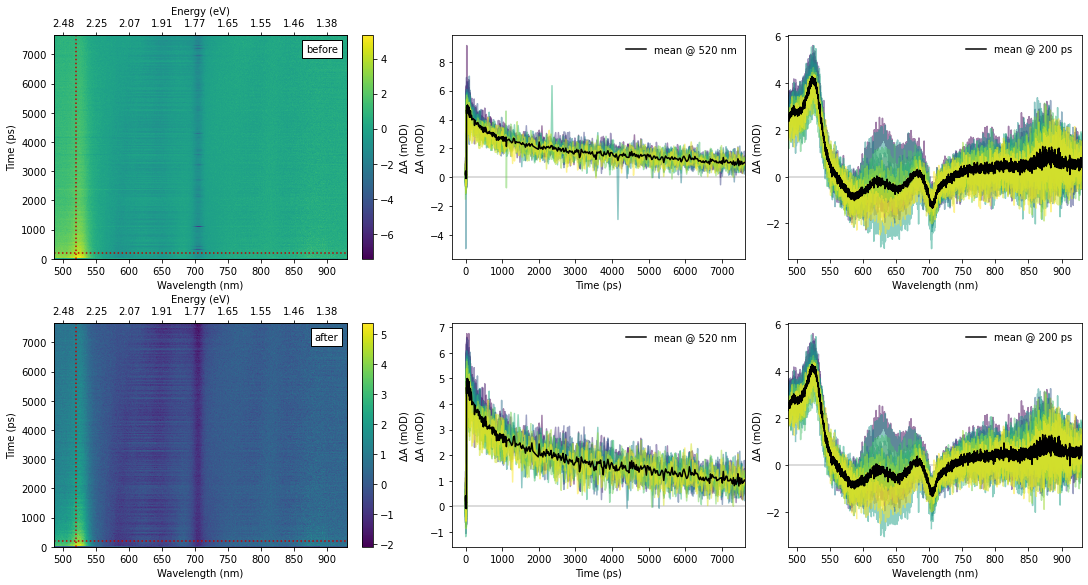

In [38]:
# Sensitivity of outlier removal (0 no effect, 1+ is large effect)
sensitivity = 0.2

# Adjust the range of intensities so everything gets plotted on the same scale
# A value of None will autoscale
z_range = (None, None)
################################################################################ 

# Build the plot panels. Six-up, with "before" above and "after" below.
fig, ((bx_hm, bx_t, bx_s), (ax_hm, ax_t, ax_s)) = plt.subplots(2, 3, figsize=(15,8), constrained_layout=True)

# Upper-left, heatmap before
# Add an upper eV scale if wavelength in nm
if z['raw/wavelength'].attrs['units'] == "nm":
    bx_ev = bx_hm.twiny()
    bx_ev.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f"{1240.0/x:0.2f}" if not x == 0 else 0))
    bx_ev.set_xlabel("Energy (eV)")
    bx_hm.callbacks.connect('xlim_changed', lambda ax_wl: bx_ev.set_xlim(ax_wl.get_xlim()))
# Add the heatmap plot
img = bx_hm.pcolormesh(z['raw/wavelength'], z['raw/time'], data_mean, vmin=z_range[0], vmax=z_range[1], shading="auto", cmap=cmap, rasterized=True)
# Add lines to indicate where slices are taken
bx_hm.axhline(t, color="#c00000", linestyle="dotted")
bx_hm.axvline(wl, color="#c00000", linestyle="dotted")
# Add colourbar scale
cb = fig.colorbar(img, ax=bx_hm)
cb.ax.set_ylabel(f"{z['raw/data'].attrs['units']} (mOD)")
# Label axes etc
bx_hm.set_xlabel(f"Wavelength ({z['raw/wavelength'].attrs['units']})")
bx_hm.set_ylabel(f"Time ({z['raw/time'].attrs['units']})")
bx_hm.add_artist(mpl.offsetbox.AnchoredText("before", loc="upper right"))

# Upper-centre, temporal slice before
# Add a horizontal zero line
bx_t.axhline(0, c="#d0d0d0")
# Plot each included scan
for s_i, scan in enumerate(s_slice[include_scans]):
    bx_t.plot(z["raw/time"], 1e3*scan, c=colours[s_i], alpha=0.5)
# Add a trace for the mean
bx_t.plot(z["raw/time"], 1e3*np.nanmean(s_slice[include_scans], axis=0), c="black", label=f"mean @ {wl:0.0f} {z['raw/wavelength'].attrs['units']}")
# Label axes etc
bx_t.set_xlabel(f"Time ({z['raw/time'].attrs['units']})")
bx_t.set_ylabel(f"{z['raw/data'].attrs['units']} (mOD)")
bx_t.set_xlim(None, np.max(z['raw/time']))
bx_t.set_ylim(z_range)
bx_t.legend(frameon=False)

# Upper-right, spectral slice before
bx_s.axhline(0, c="#d0d0d0")
# Plot each included scan
for s_i, scan in enumerate(t_slice[include_scans]):
    bx_s.plot(z["raw/wavelength"], 1e3*scan, c=colours[s_i], alpha=0.5)
# Add a trace for the mean
bx_s.plot(z["raw/wavelength"], 1e3*np.nanmean(t_slice[include_scans], axis=0), c="black", label=f"mean @ {t:0.0f} {z['raw/time'].attrs['units']}")
# Label axes etc
bx_s.set_xlabel(f"Wavelength ({z['raw/wavelength'].attrs['units']})")
bx_s.set_ylabel(f"{z['raw/data'].attrs['units']} (mOD)")
bx_s.set_xlim(np.min(z['raw/wavelength']), np.max(z['raw/wavelength']))
bx_s.set_ylim(z_range)
bx_s.legend(frameon=False)

# Clean up the data using our outlier removal algorithm
data_mean_clean = 1e3*np.nanmean(mask_outliers(z['raw/data'][:][include_scans], sensitivity=sensitivity), axis=0)
s_slice_clean = mask_outliers(s_slice, sensitivity=sensitivity)
t_slice_clean = mask_outliers(t_slice, sensitivity=sensitivity)
# Now plot the "after" results

# Lower-left, heatmap after
# Add an upper eV scale if wavelength in nm
if z['raw/wavelength'].attrs['units'] == "nm":
    ax_ev = ax_hm.twiny()
    ax_ev.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f"{1240.0/x:0.2f}" if not x == 0 else 0))
    ax_ev.set_xlabel("Energy (eV)")
    ax_hm.callbacks.connect('xlim_changed', lambda ax_wl: ax_ev.set_xlim(ax_wl.get_xlim()))
# Add the heatmap plot
img = ax_hm.pcolormesh(z['raw/wavelength'], z['raw/time'], data_mean_clean, vmin=z_range[0], vmax=z_range[1], shading="auto", cmap=cmap, rasterized=True)
# Add lines to indicate where slices are taken
ax_hm.axhline(t, color="#c00000", linestyle="dotted")
ax_hm.axvline(wl, color="#c00000", linestyle="dotted")
# Add colourbar scale
cb = fig.colorbar(img, ax=ax_hm)
cb.ax.set_ylabel(f"{z['raw/data'].attrs['units']} (mOD)")
# Label axes etc
ax_hm.set_xlabel(f"Wavelength ({z['raw/wavelength'].attrs['units']})")
ax_hm.set_ylabel(f"Time ({z['raw/time'].attrs['units']})")
ax_hm.add_artist(mpl.offsetbox.AnchoredText("after", loc="upper right"))

# Lower-centre, temporal slice after
# Add a horizontal zero line
ax_t.axhline(0, c="#d0d0d0")
# Plot each included scan
for s_i, scan in enumerate(s_slice_clean[include_scans]):
    ax_t.plot(z["raw/time"], 1e3*scan, c=colours[s_i], alpha=0.5)
# Add a trace for the mean
ax_t.plot(z["raw/time"], 1e3*np.nanmean(s_slice_clean[include_scans], axis=0), c="black", label=f"mean @ {wl:0.0f} {z['raw/wavelength'].attrs['units']}")
# Label axes etc
ax_t.set_xlabel(f"Time ({z['raw/time'].attrs['units']})")
ax_t.set_ylabel(f"{z['raw/data'].attrs['units']} (mOD)")
ax_t.set_xlim(None, np.max(z['raw/time']))
ax_t.set_ylim(z_range)
ax_t.legend(frameon=False)

# Lower-right, spectral slice after
ax_s.axhline(0, c="#d0d0d0")
# Plot each included scan
for s_i, scan in enumerate(t_slice_clean[include_scans]):
    ax_s.plot(z["raw/wavelength"], 1e3*scan, c=colours[s_i], alpha=0.5)
# Add a trace for the mean
ax_s.plot(z["raw/wavelength"], 1e3*np.nanmean(t_slice_clean[include_scans], axis=0), c="black", label=f"mean @ {t:0.0f} {z['raw/time'].attrs['units']}")
# Label axes etc
ax_s.set_xlabel(f"Wavelength ({z['raw/wavelength'].attrs['units']})")
ax_s.set_ylabel(f"{z['raw/data'].attrs['units']} (mOD)")
ax_s.set_xlim(np.min(z['raw/wavelength']), np.max(z['raw/wavelength']))
ax_t.set_ylim(z_range)
ax_s.legend(frameon=False)

# Save the image if desired
#fig.savefig(f"cleaned_comparison_6up.pdf", dpi=300)
pass # Hide notebook output text